<a href="https://colab.research.google.com/github/Xylot0/ml-student/blob/main/BE_session1_probleme1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problème 1:





Dans ce problème, il s'agit de reconstruire un champ spatialisé cible à partir d'un prédicteur spatialisé et d'observations ponctuelles.  
Dans la première partie, on adapte simplement la procédure de régression pixel à pixel standard au cas où les données cibles ne sont renseignées qu'en quelques pixels (observations "ponctuelles").\
Dans la seconde partie, on entraîne un réseau à prendre les deux types de données, champ spatialisé et observations ponctuelles, en entrée pour reconstruire au mieux la cible complète.

**NB**: Il vaut mieux traiter les deux parties dans l'ordre.

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! wget https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
! mv mfh8gy5ZmfB_zaQP9HZKdDk utile_BE.py

from utile_BE import *

--2024-01-12 13:11:59--  https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21240 (21K) [application/octet-stream]
Saving to: ‘mfh8gy5ZmfB_zaQP9HZKdDk’

mfh8gy5ZmfB_zaQP9HZ 100%[===================>]  20.74K  --.-KB/s    in 0s      

2024-01-12 13:12:00 (287 MB/s) - ‘mfh8gy5ZmfB_zaQP9HZKdDk’ saved [21240/21240]



## Partie I : régression sur une cible incomplète

La fonction *gen1* permet d'échantillonner des données d'apprentissage.\
Le paramètre *p* représente la proportion de pixels au niveau desquels les observations ponctuelles sont disponibles. Ces observations ponctuelles, contenues dans le deuxième tenseur fourni par *gen1*, sont positives ou nulles. Les pixels où elles manquent sont associés à la valeur -1.\
Le troisième tenseur correspond à la cible complète (cas idéal où *p*=1). C'est elle qu'on cherche à prédire.

**NB**:
- le deuxième tenseur est une version incomplète du troisième tenseur.
- *gen1* peut être considéré comme un échantillonneur parfait des données d'apprentissage. Il ne produit jamais deux fois les mêmes images.

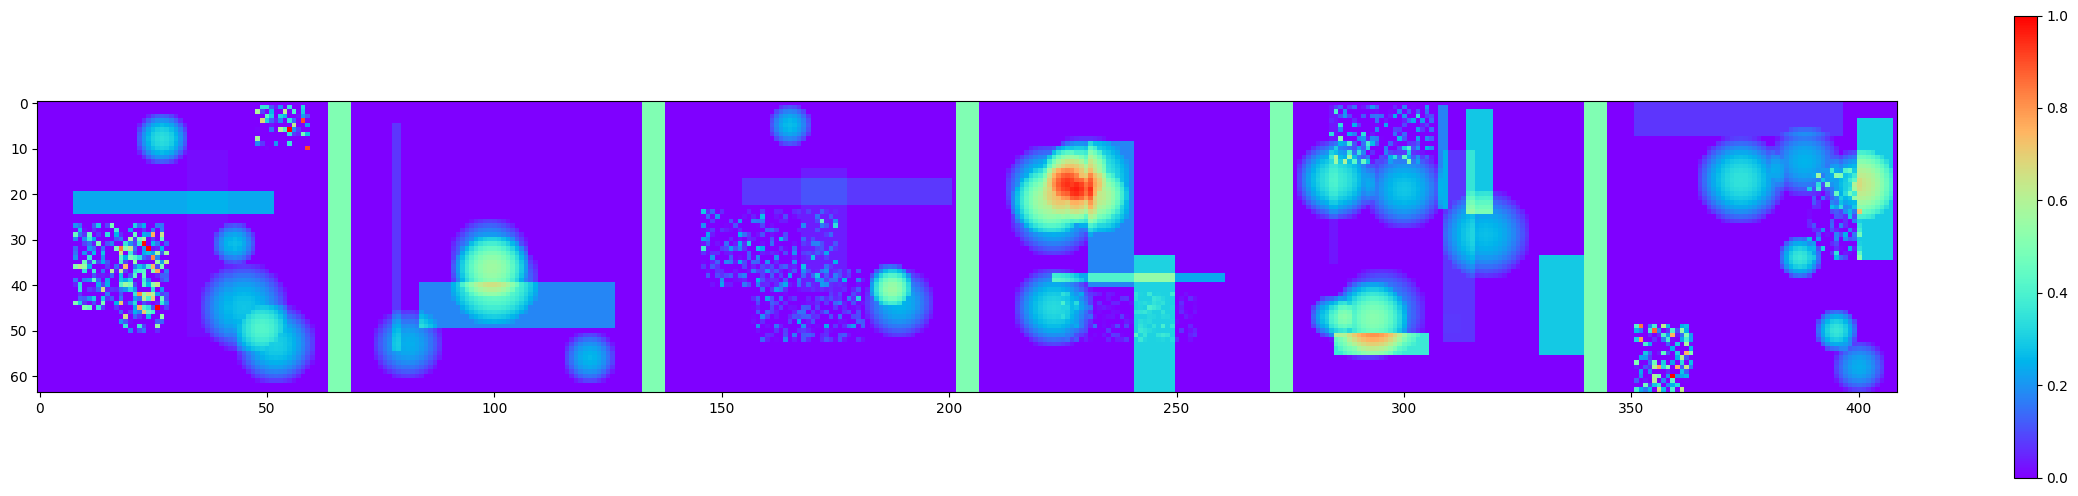

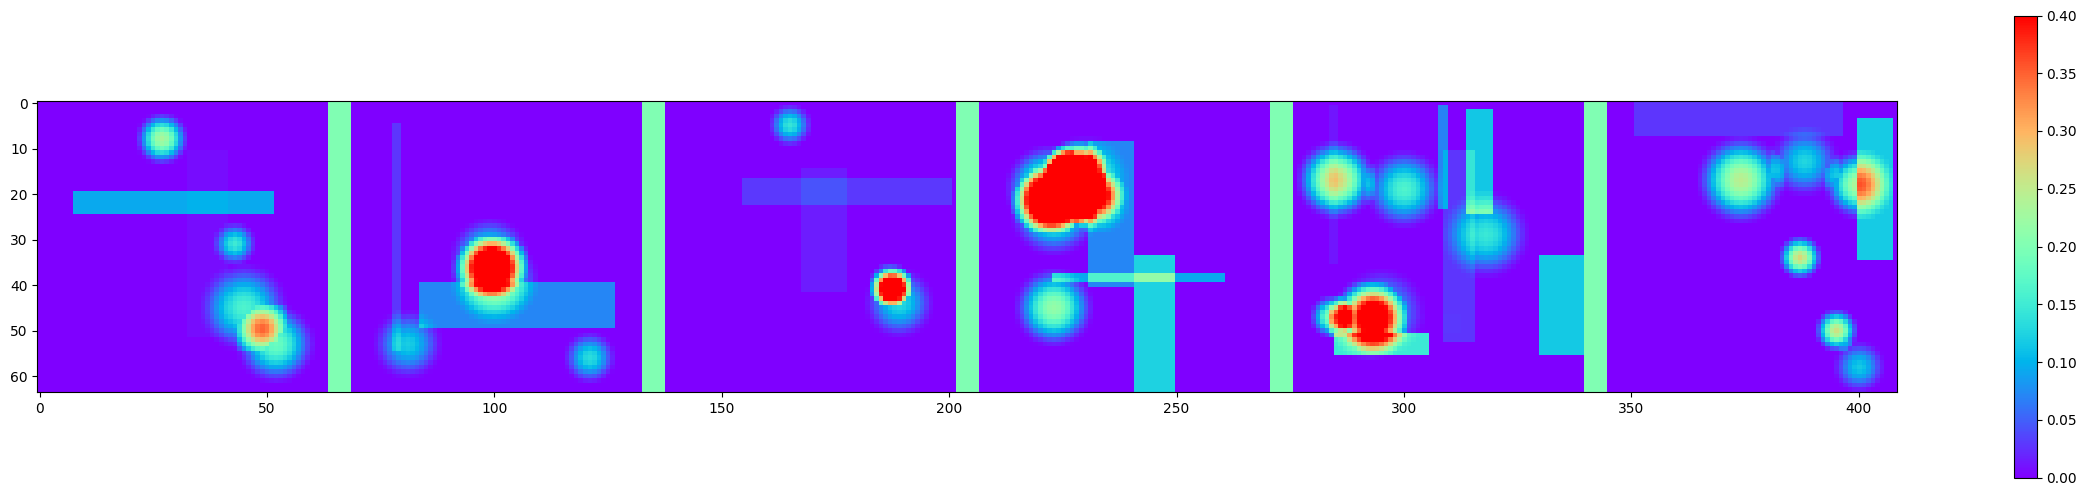

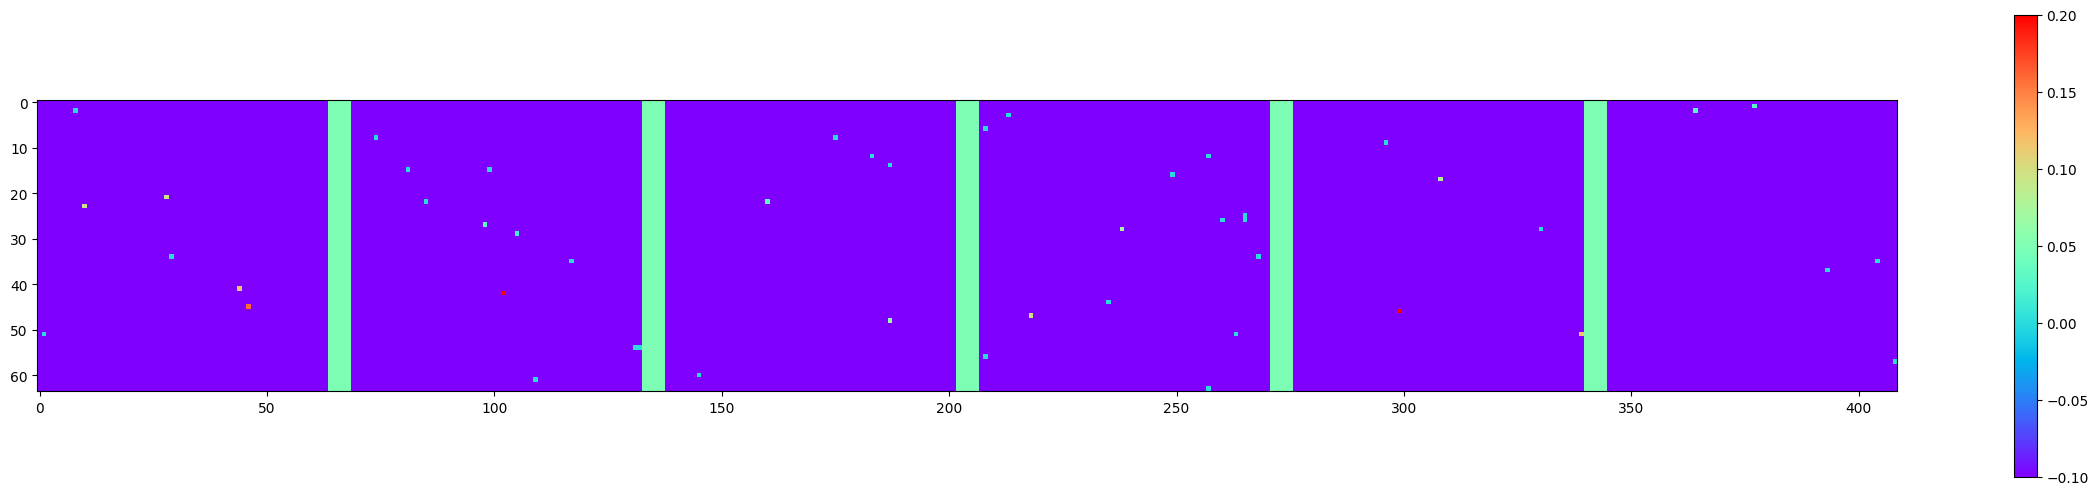

In [3]:
input,  target, fulltarget  = gen1(6,p=0.002)

# input: prédicteur spatialisé
fig0 = plt.figure(0, figsize=(30, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# fulltarget: cible complète, qu'on ne peut pas utiliser pour l'apprentissage
fig1 = plt.figure(1, figsize=(30, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0, max_scale=0.4)

# target: cible incomplète
fig2 = plt.figure(2, figsize=(30, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1, max_scale=0.2)

**Q1** Pour entraîner un réseau de neurones sur des cibles incomplètes, on définit la fonction de coût *masked_MAE*.
Préciser le rôle du tenseur *mask*. Tester le bon fonctionnement de *masked_MAE* à l'aide d'un batch généré par *gen1*.
       


In [4]:
def masked_MAE(output, target, mask):
  return (torch.abs(output-target))[mask].mean()

Le tenseur mask permet de sélectionner uniquement certaines données dans le calcul de la moyenne, celles ou le masque à la valeur "Vrai". Comme il manque certaines données dans la target, on ne souhaite pas que le calcul de la moyenne prenne en comote ces valeurs manquantes

In [7]:
input, target, fulltarget = gen1(6, p=0.002)

mask = torch.ones_like(fulltarget).long()

mae_result = masked_MAE(output=target, target=fulltarget, mask=mask)

print("Résultat de masked_MAE :", mae_result.item())

Résultat de masked_MAE : 1.0359662771224976


**Q2** Pour cette tâche de régression, nous allons entraîner un UNet. Précisez les différentes couches contenues dans ce UNet, leur rôle et le nombre de poids total qu'il contient.

In [8]:
fcn = UNet(1,1,16)

In [9]:
print(fcn)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

Dans un UNet, il y a :
- des couches de convolution, qui sont formées par des noyaux qui contiennent les poids du réseau.
- des maxpooling, qui réduisent la dimension spatiale de l'image tout en préservant les caractériqtiques importantes.
- des couches de convolutions transposées, qui ont le rôle inverde des maxpooling, c'est-à-dire que ces couches vont progressivement augmenter la dimension spatiale de l'image, afin de permettre une segmentation plus précise, car elles affinent la précision des détails de l'image.
- des fonctions d'activation, ici des ReLU, pour apporter de la non-linéarité au réseau, afin d'apprendre des relations plus complexes dans les données.

In [12]:
pconv = 0
pmaxp = 0
pconvt = 0
pact = 0

for module in fcn.modules():
  if isinstance(module, nn.Conv2d):
    for parameter in module.parameters():
      pconv += torch.numel(parameter)
  if isinstance(module, nn.ConvTranspose2d):
    for parameter in module.parameters():
      pconvt += torch.numel(parameter)
  if isinstance(module, nn.BatchNorm2d):
    for parameter in module.parameters():
      pmaxp += torch.numel(parameter)
  if isinstance(module, nn.ReLU):
    for parameter in module.parameters():
      pact += torch.numel(parameter)

print("Nombre de poids dans les couches de convolution : " + str(pconv))
print("Nombre de poids dans les maxpoolings : " + str(pmaxp))
print("Nombre de poids dans les couches de convolution transposées : " + str(pconvt))
print("Nombre de poids dans les fonctions d'activation : " + str(pact))


Nombre de poids dans les couches de convolution : 837522
Nombre de poids dans les maxpoolings : 1984
Nombre de poids dans les couches de convolution transposées : 87280
Nombre de poids dans les fonctions d'activation : 0


**Q3** Dans la fonction *run_train* coder une époque de l'entraînement du UNet en exploitant la cible incomplète. Rester sur CPU. **Commenter votre code**. \
On utilisera les hyperparamètres suivants :

In [13]:
# optim: Adam, lr = 0.001
# batch par époque: 50
# taille d'un batch: 64
# p = 0.002

In [18]:
def run_train(fcn, optimizer, p = 0.002):

  for i in range(nbatches):
        #Load inputs

        # Génération grâce à la fonctio  gen1
        input, target, full_target = gen1(batchsize, p = p)

        # On met à zéro les gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # On calcule la loss et les gradients
        loss = masked_MAE(output,target,mask=mask)
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

        del target, input, loss
        torch.cuda.empty_cache()

  return fcn, optimizer

In [19]:
optimizer = optim.Adam(fcn.parameters(), 0.001)
nbatches = 50
batchsize = 64
p = 0.002

In [20]:
import time
t = time.time()
run_train(fcn, optimizer, p = 0.002)
print(time.time() - t)

epoch loss : 

0.639159
119.07805395126343


**Q4** Dans la fonction *run_train_gpu*, passer la phase d'entraînement sur GPU. Evaluer le speed-up.

In [25]:
def run_train_gpu(fcn, optimizer, p = 0.002):

  for i in range(nbatches):
        #Load inputs

        # Generation
        input, target, full_target = gen1(batchsize, p = p)

        # On passe sur GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = masked_MAE(output,target,mask=mask)
        loss.backward()

        # Update weights
        optimizer.step()

        del target, input, loss
        torch.cuda.empty_cache()

  return fcn, optimizer

In [22]:
optimizer = optim.Adam(fcn.parameters(), 0.001)
nbatches = 50
batchsize = 64
p = 0.002

In [24]:
# pour le calcul du speed-up
import time
t = time.time()
run_train_gpu(fcn.cuda(), optimizer, p = 0.002)
print(time.time() - t)

epoch loss : 

0.2594604
10.453644275665283


Comparaison des temps d'exécution :
- Avec CPU : 119 secondes
- Avec GPU : 10.5 secondes

Le speed up est de $\frac{119}{10.5}$ soit 11.33.

Dans les questions suivantes, nous allons chercher à évaluer l'effet de la densité des observations ponctuelles *p* sur les performances en généralisation au cours de l'entraînement.

**Q5**  Pour comparer les performances en généralisation au cours de l'entraînement, on se permet d'utilise la MAE entre outputs et cibles **complètes**. En général, peut-on se permettre d'utiliser les mêmes données que celles qui ont été utilisées pendant la phase d'entraînement ? Est-ce le cas ici ? \
Dans la fonction *run_trainval_gpu()* suivante, évaluer les performances en généralisation au cours de l'entraînement (variable *epoch_MAE_validation*).
Eviter tout calcul superflux.

En général non, car cela entraînera de l'overfitting sur les données d'entraînement, ce qui diminuerait la qualité et la précision réelle du modèle. C'est pour cela que l'on divise toujours notre ensemble de données en un ensemble d'entraînement, un ensemble de validation et un ensemble de test.

Ici, comme la fonction gen1 ne génère jamais deux fois les mêmes images, il n'y a pas de risque d'overfitting, et donc il n'y a pas de problème à évaluer les performances en généralisation au cours de l'entraînement.

In [33]:
def run_trainval_gpu(fcn, optimizer, p = 0.002):

    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input, target, full_target = gen1(batchsize, p=p)

        # go to GPU
        input = input.cuda()
        target = target.cuda()
        full_target = full_target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = masked_MAE(output, full_target, mask)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_MAE_validation = np.mean(epoch_losses)
    print('epoch loss : \n')
    print(epoch_MAE_validation)

    return fcn, optimizer, epoch_MAE_validation

In [34]:
fcn, optimizer, MAE_validation = run_trainval_gpu(fcn.cuda(), optimizer, p = 0.002)

epoch loss : 

0.39511505


**Q6** Générer deux versions du UNet précédent comportant les **mêmes poids initiaux**. Entraîner ces versions sur cinquante époques, chacun pour une valeur de *p* différente : *p* = 0.01 et *p* = 0.002.
**Commenter votre code**. Tracer et discuter les courbes d'apprentissage.

In [35]:
nepochs = 50
scores_1  = []
scores_2  = []

fcn = UNet(1,1,16)
fcn2 = UNet(1,1,16)

# J'initialise deux vecteurs comportant la loss pour chaque epoch
train_losses1 = []
train_losses2 = []

for epoch in range(nepochs):

  print("Epoch n° " + str(epoch))

  print("UNet 1")
  _, _, MAE_validation1 = run_trainval_gpu(fcn.cuda(), optimizer, p = 0.01) #
  train_losses1.append(MAE_validation1)

  print("UNet 2")
  _, _, MAE_validation2 = run_trainval_gpu(fcn2.cuda(), optimizer, p = 0.002)
  train_losses2.append(MAE_validation2)


epoch loss : 

0.20408364
epoch loss : 

0.21940547
epoch loss : 

0.19482237
epoch loss : 

0.2119475
epoch loss : 

0.19979352
epoch loss : 

0.22106989
epoch loss : 

0.20412922
epoch loss : 

0.21850096
epoch loss : 

0.20615382
epoch loss : 

0.21504067
epoch loss : 

0.1943343
epoch loss : 

0.20747873
epoch loss : 

0.18981747
epoch loss : 

0.20783436
epoch loss : 

0.19006847
epoch loss : 

0.22760096
epoch loss : 

0.21335235
epoch loss : 

0.21395896
epoch loss : 

0.19965518
epoch loss : 

0.21476214
epoch loss : 

0.19999632
epoch loss : 

0.21560064
epoch loss : 

0.19274938
epoch loss : 

0.21381025
epoch loss : 

0.19254294
epoch loss : 

0.22266394
epoch loss : 

0.19119214
epoch loss : 

0.21944419
epoch loss : 

0.19783144
epoch loss : 

0.21815413
epoch loss : 

0.19681366
epoch loss : 

0.213771
epoch loss : 

0.19055142
epoch loss : 

0.2153282
epoch loss : 

0.20322405
epoch loss : 

0.20835114
epoch loss : 

0.1923634
epoch loss : 

0.2129973
epoch loss : 

0.18

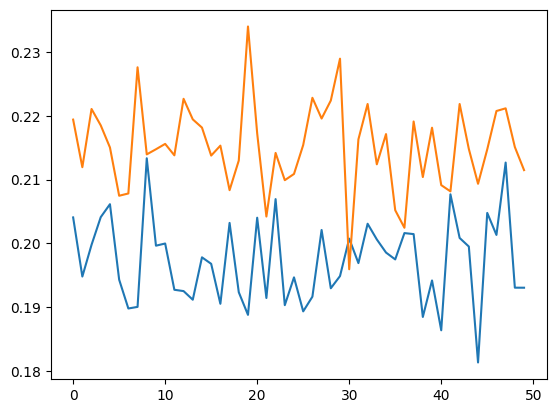

In [36]:
plt.plot(train_losses1)
plt.plot(train_losses2)

**Q7** Combien faut-il d'époques supplémentaires au deuxième *fcn* pour rattraper le premier ?

## **Partie II** : cas où les observations ponctuelles peuvent aussi servir d'entrées.

Dans cette partie, nous supposons que les observations ponctuelles sont disponibles non seulement pendant l'apprentissage, mais aussi en phase d'inférence.
Il devient donc possible de l'utiliser comme une entrée.

Avec la fonction *gen2*, cela va même s'avérer nécessaire : les observations ponctuelles contiennent une information essentielle à la prédiction de la cible complète.

En effet, le premier tenseur founi par *gen2* (ligne 1 ci-dessous) permet de dire où sont les pixels associés à des valeurs non nulles dans la cible complète (ligne 2).
Par contre, ce premier tenseur ne suffit pas à préciser l'intensité du signal cible : pour certaines cellules (premier type de cellules, en rouge sur la troisième ligne) le signal cible est plus fort que sur le premier tenseur, alors que pour d'autres cellules (deuxième type de cellule, en cyan), il est plus faible. Et rien dans le premier tenseur n'indique à quel type de cellule on a affaire.

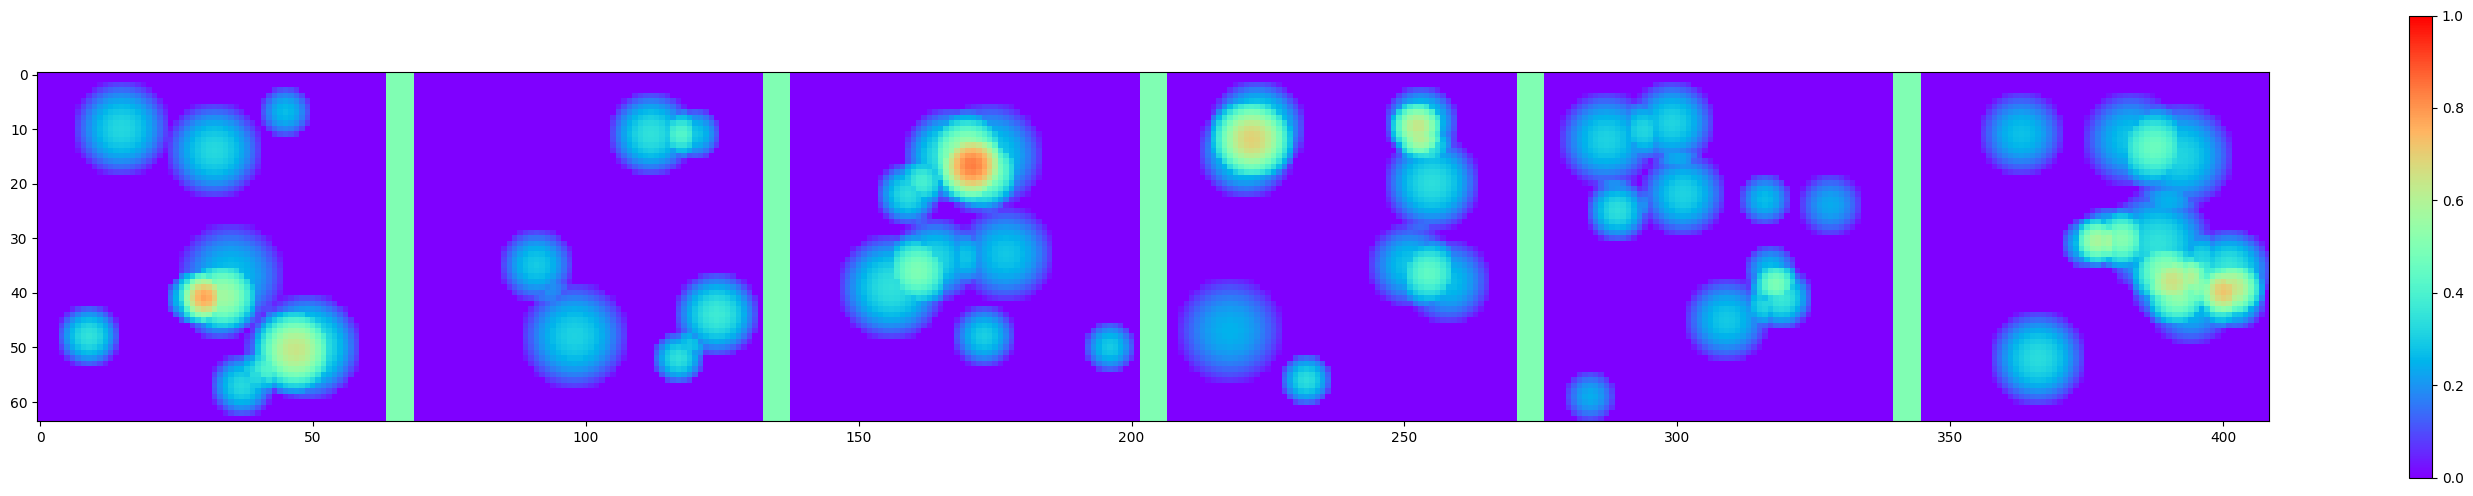

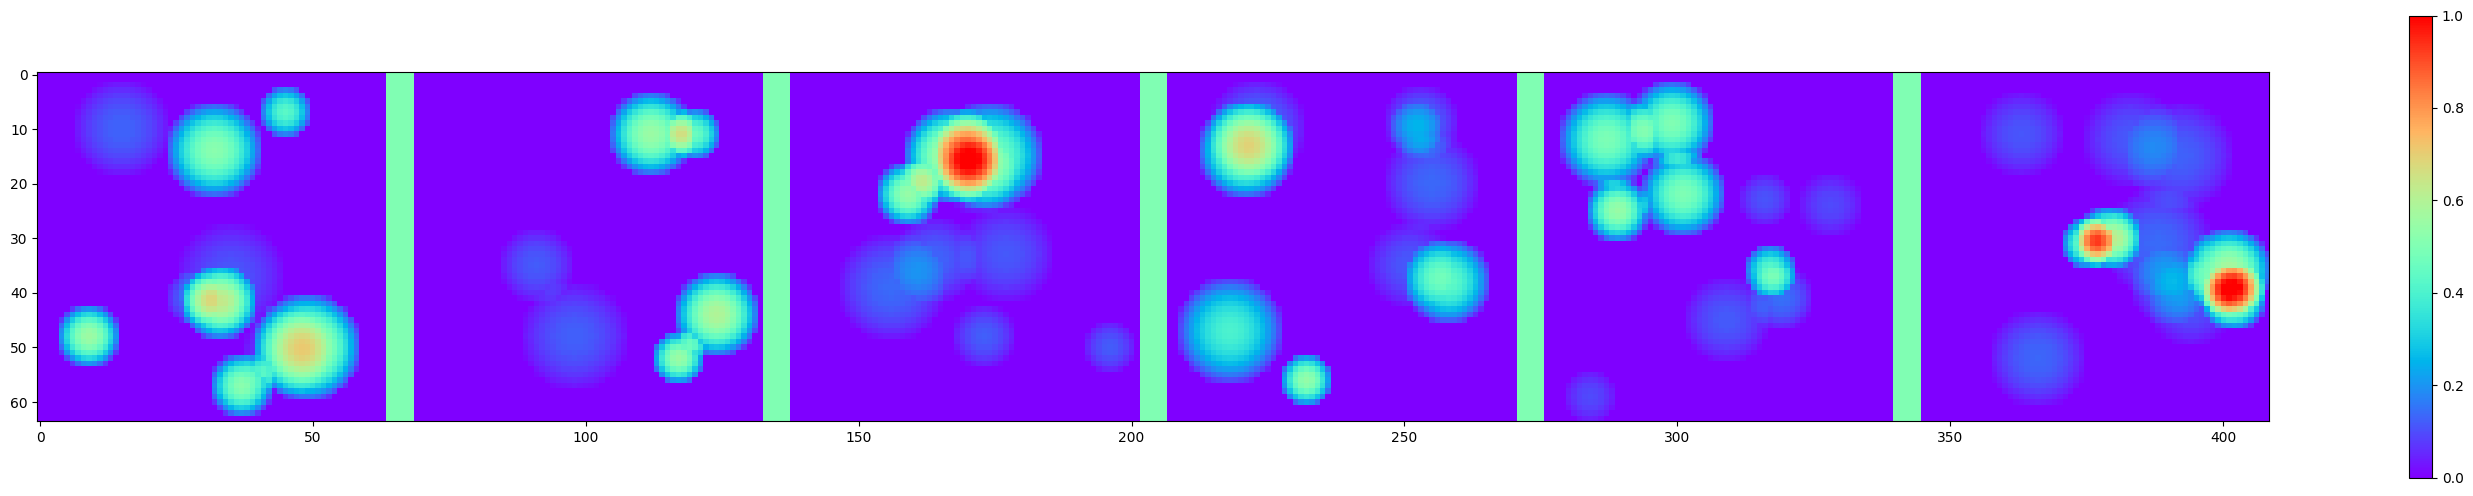

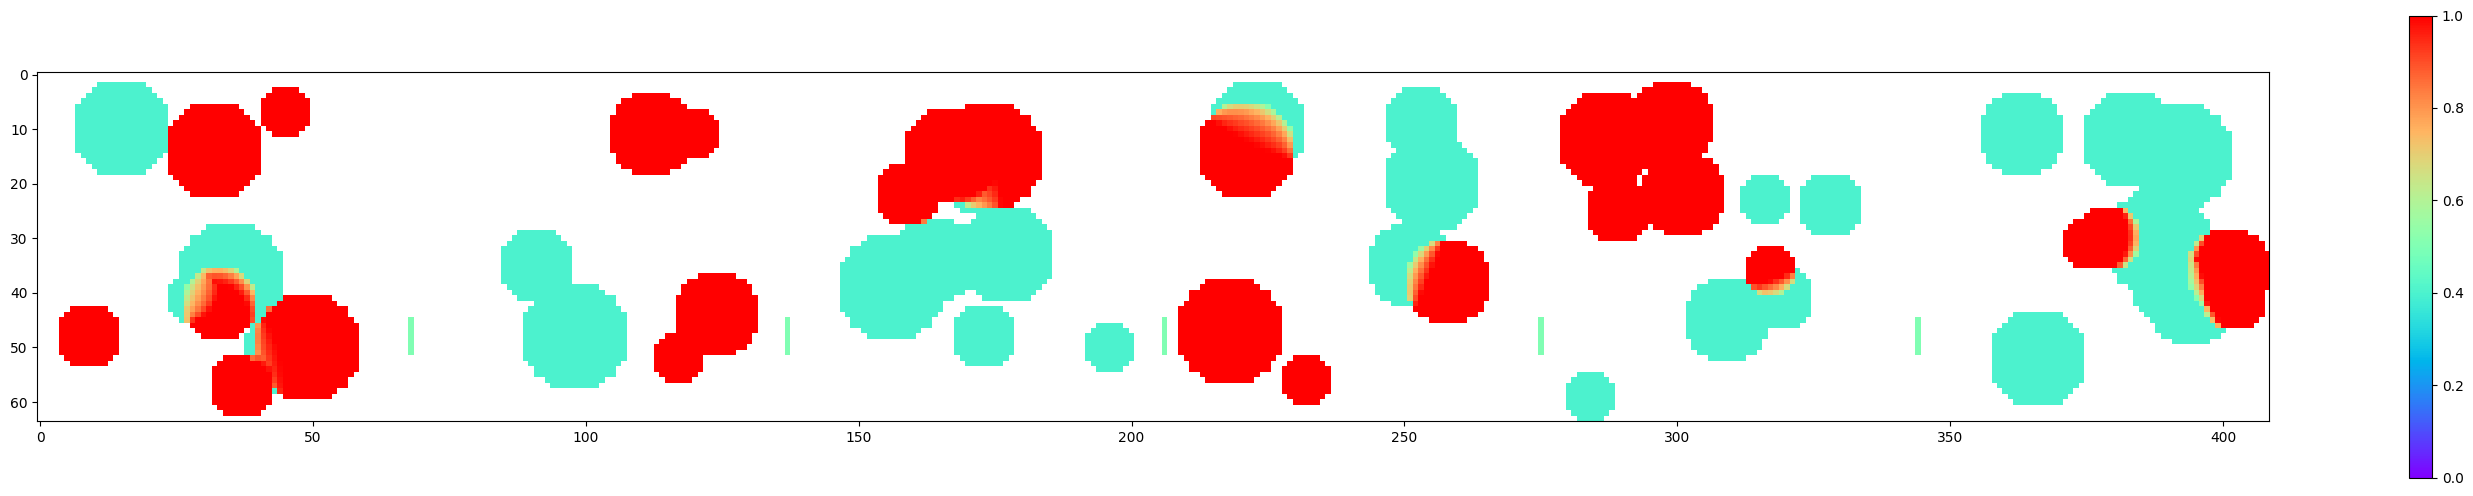

In [37]:
input, target, fulltarget  = gen2(6,0.01)

# ligne 1: le prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ligne 2: le signal cible complet où les deux types de cellules apparaissent
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

# ligne 3: le rapport entre les deux
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((fulltarget/input), 6, fig1, k=0, min_scale=0,max_scale=1)

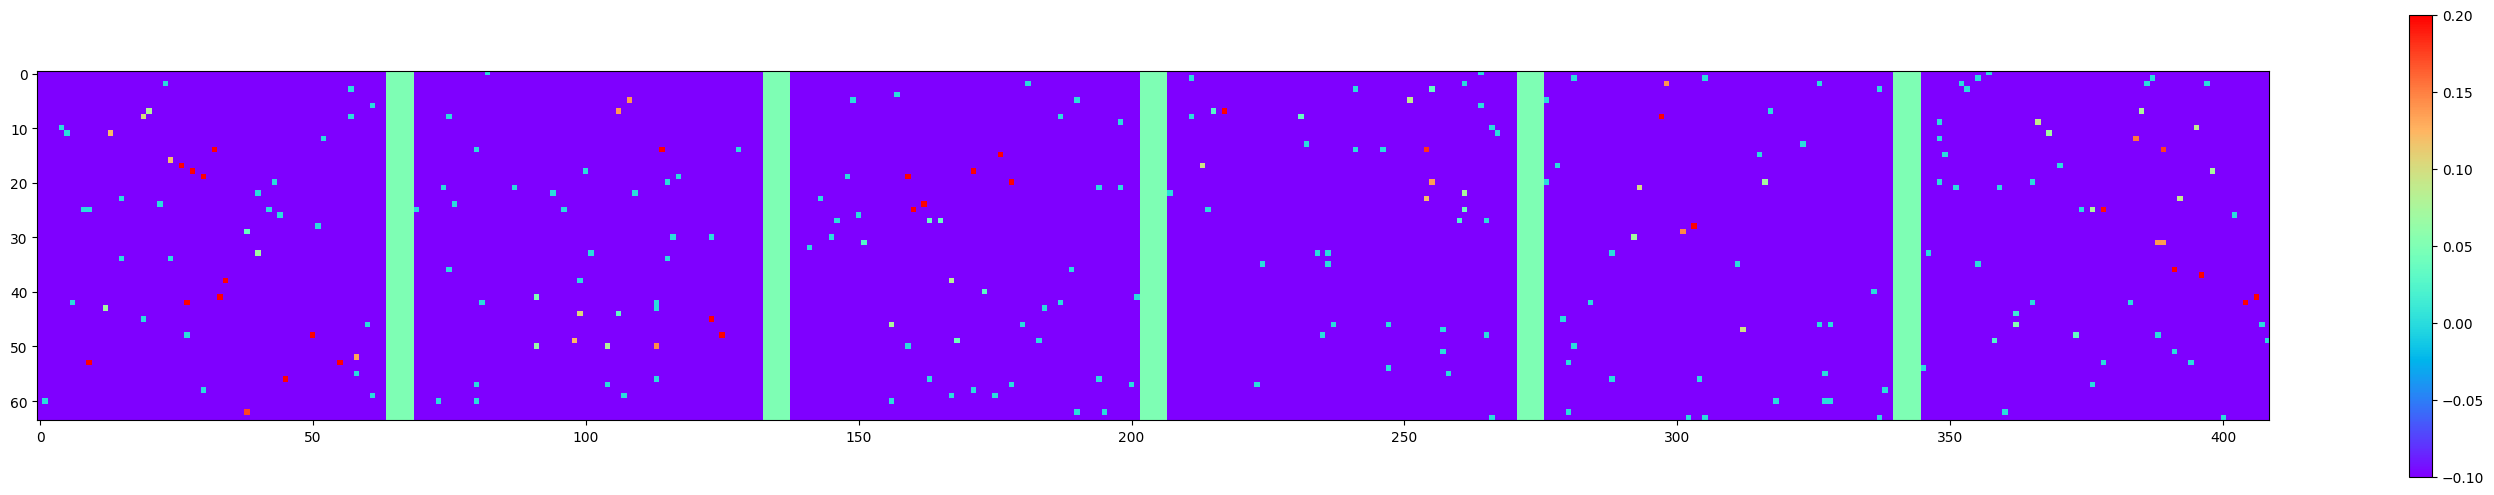

In [38]:
# les observations ponctuelles:
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2)

Comme dans la partie I, les observations ponctuelles sont les seules parties de la cible disponibles au cours de l'entraînement. Mais, comme expliqué au-dessus, ces observations ponctuelles seront aussi disponibles en phase d'inférence. Comme elles contiennent une information essentielle, il va donc s'agir d'entraîner le réseau à les exploiter à la fois comme cibles et comme entrées.


**NB:** De même que dans la partie I, dans le deuxième tenseur les valeurs manquantes sont codées par -1 et toutes les autres valeurs sont positives ou nulles.

**Q1** Dans un premier temps, entraîner un UNet **en n'utilisant que le premier tenseur ("input") en entrée**. Toutes les observations ponctuelles disponibles peuvent être utilisées dans la cible.
Les autres consignes sont :
- Choisir la fonction de coût de manière à estimer la **moyenne conditionnelle à l'entrée**.
- Pour la phase de validation, évaluer l'écart entre la cible complète et les outputs de la phase d'entraînement (comme dans la partie I).
- Utiliser les hyperparamètres ci-dessous:

In [39]:
import torch.optim as optim
fcn = UNet(1,1,16).cuda()
nepochs = 15
nbatches = 100
batchsize = 64
p = 0.01

In [ ]:
scores_1  = []

criterion = nn.MSELoss()

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input, target, full_target = gen2(batchsize, p)

        # go to GPU
        input = input.cuda()
        target = target.cuda()
        full_target = full_target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update weights
        optimizer.step()

    fcn.eval()

    with torch.no_grad():
        for i in range(nbatches):
          input, target, full_target = gen2(batchsize, p)

          input = input.cuda()
          target = target.cuda()
          full_target = full_target.cuda()

          optimizer.zero_grad()
          output = fcn(input)

          loss1 = masked_MAE(output, full_target, mask)

          optimizer.step()

          epoch_losses.append(loss1.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    scores_1.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.16910054
Epoch 1
epoch loss : 

0.16789122
Epoch 2
epoch loss : 

0.1703211
Epoch 3
epoch loss : 

0.16887374
Epoch 4
epoch loss : 

0.16780466
Epoch 5
epoch loss : 

0.16861834
Epoch 6


**Q2** Pourquoi les performances stagnent-elles ? Visualiser quelques outputs et vérifier que le réseau restitue simplement le champ d'entrée. Expliquer pourquoi, intuitivement.

Dans ce cas on n'utilise que le premier tenseur en entrée de l'entraînement, qui n'indique que les endroits ou les valeurs cibles ne sont pas nulles, mais n'ont pas d'informations sur l'intensité de la cible. Ainsi les performances ne peuvent pas être améliorées au cours de l'entraînement.

Le réseau a appris concrètement où étaient les valeurs non nulles, mais sans plus d'informations, donc c'est naturel d'obtenir le champ d'entrée en sortie.

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p)

output = fcn(input.cuda())

fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

On cherche maintenant à utiliser une partie des observations ponctuelles comme prédicteurs.\
Une idée simple consiste à définir un deuxième tenseur d'entrée ne comptant (environ) qu'une observation ponctuelle sur deux. Les autres observations ponctuelles sont quant elles utilisées comme cible.

**Q3** Mettre en oeuvre cette idée.

**Remarques:**
- La fonction *torch.bernoulli* permet de masquer environ 50% des valeurs d'un tenseur...
- Attention à la mutabilité des tenseurs pytorch.

In [ ]:
...

**Q4** Procéder à un apprentissage sur dix époques, comparer la courbe d'apprentissage obtenue avec la précédente et expliquer.

In [ ]:
nepochs = 15
fcn = UNet(2,1,16).cuda()

...

In [ ]:
scores_2  = []

...

**Q5** Visualiser des batches d'outputs. Dans quelle mesure le réseau parvient-il à lever l'ambiguïté sur le type de cellule en présence ?

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p = 0.005)

# prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# obs ponctuelles et cible complète
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((target>=0) + fulltarget, 6, fig1, k=0, min_scale=0.,max_scale=1)

output = ...

...

**Q6** Au cours d'un apprentissage, nous avons utilisé (environ) la moitié des observations ponctuelles à disposition. Quel peut être le défaut de cette approche ? Jouer sur la valeur de *p* pour illustrer votre propos.

**Q7** Pour prédire la valeur d'un pixel, un FCN permet de prendre en compte le contexte, c'est à dire l'information contenue dans un large voisinage autour du pixel d'intérêt.\
Cette qualité était-elle nécessaire pour traiter la **partie I** du problème ? Etait-elle nécessaire pour traiter la **partie II** ? Justifier dans les deux cas.